In [ ]:
#!pip install tensorflow
# !pip install -U scikit-learn
# !pip install mediapipe

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import cv2
import numpy as np
import os
import pandas as pd
from PIL import Image
import numpy as np
import pandas as pd
# Import the required libraries.
import os
import cv2
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
# Kích thướng mỗi frame
IMAGE_WIDTH,  IMAGE_HEIGHT = 160, 120
# số lượng frame sẽ lấy ở mỗi video
SEQUENCE_LENGTH = 20
# Những hành động sẽ nhận dạng
CLASSES_LIST = ['Your', 'Love', 'Sleep', 'Name',
                'What', 'Read', 'I', 'Bye', 'You', 'Eat', 'Hello']

# Link thư mục chứa video train
DATASET_DIR = './drive/MyDrive/PBL5'
# DATASET_DIR = './'


In [5]:
dataset = np.load(f'{DATASET_DIR}/dataset_2.npz')
features=dataset['features']
labels=dataset['labels']
video_files_paths=dataset['video_files_paths']

In [6]:
features.shape

(209, 20, 120, 160, 3)

In [7]:
one_hot_encoded_labels = to_categorical(labels)

In [8]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

2023-03-24 22:49:32.966380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nhamcotdo/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-24 22:49:32.967090: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 22:49:32.967138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nhamcotdo): /proc/driver/nvidia/version does not exist
2023-03-24 22:49:32.970053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 118, 158, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 59, 79, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 59, 79, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 57, 77, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 29, 39, 8)    0         
 3D)                                                             
                                                        

In [ ]:
# plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [15]:

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

In [ ]:
# !pip install pydot

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


In [ ]:
# # Start training the model.
# convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
 	
# # Evaluate the trained model.
# model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [ ]:
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# # Define the string date format.
# # Get the current Date and Time in a DateTime Object.
# # Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
# model_file_name = f'{DATASET_DIR}/convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# # Save your Model.
# convlstm_model.save(model_file_name)

In [ ]:
# plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
# plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 120, 160, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 30, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 30, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 30, 40, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 7, 10, 32)   

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


In [ ]:
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 1 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/100
125/125 [==============================] - 29s 200ms/step - loss: 2.4941 - accuracy: 0.0880 - val_loss: 2.4250 - val_accuracy: 0.1429
Epoch 2/100
125/125 [==============================] - 22s 179ms/step - loss: 2.3631 - accuracy: 0.1040 - val_loss: 2.3903 - val_accuracy: 0.1667
Epoch 3/100
125/125 [==============================] - 24s 191ms/step - loss: 2.2991 - accuracy: 0.1600 - val_loss: 2.3802 - val_accuracy: 0.2143
Epoch 4/100
125/125 [==============================] - 23s 182ms/step - loss: 2.2479 - accuracy: 0.1840 - val_loss: 2.3141 - val_accuracy: 0.2143
Epoch 5/100
125/125 [==============================] - 24s 188ms/step - loss: 2.1964 - accuracy: 0.2080 - val_loss: 2.2865 - val_accuracy: 0.1905
Epoch 6/100
125/125 [==============================] - 24s 189ms/step - loss: 2.1414 - accuracy: 0.2160 - val_loss: 2.2045 - val_accuracy: 0.2381
Epoch 7/100
125/125 [==============================] - 23s 183ms/step - loss: 2.0705 - accuracy: 0.2080 - val_loss: 2.1794 -

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2023-03-24 23:13:32.602659: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


2/2 [==============================] - 3s 577ms/step - loss: 1.2290 - accuracy: 0.7143


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'{DATASET_DIR}/LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

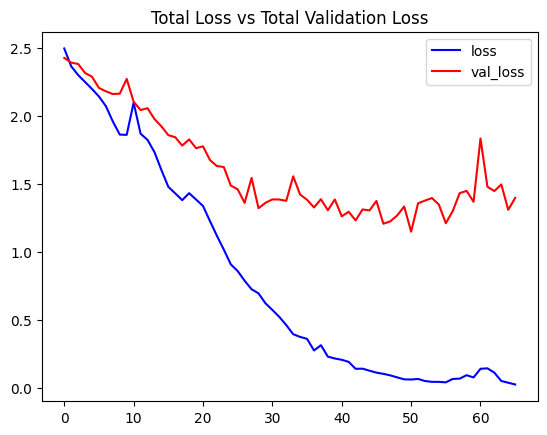

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

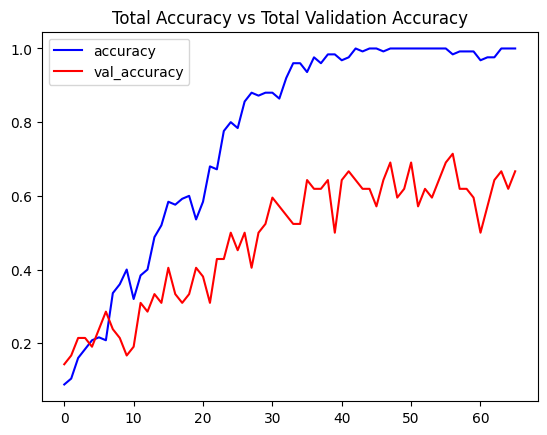

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
LRCN_model.load_weights(f'{DATASET_DIR}/LRCN_model___Date_Time_2023_03_23__17_07_44___Loss_0.8039475679397583___Accuracy_0.7857142686843872.h5') 
LRCN_model.evaluate(features_test, labels_test)


2023-03-24 23:13:36.313443: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


2/2 [==============================] - 3s 574ms/step - loss: 0.8039 - accuracy: 0.7857


[0.8039475679397583, 0.7857142686843872]

In [10]:
def create_LRCN_model_opt():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(
        Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))5
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(
        Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(
        Conv2D(256, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, activation='tanh', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model


In [11]:
LRCN_model_opt = create_LRCN_model_opt()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 160, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 30, 40, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 30, 40, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 30, 40, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 7, 10, 64)    0

In [12]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model_opt.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


In [13]:
# Start training the model.
LRCN_model_opt_training_history = LRCN_model_opt.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 1 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/100
125/125 [==============================] - 23s 60ms/step - loss: 2.4591 - accuracy: 0.1040 - val_loss: 2.4069 - val_accuracy: 0.0714
Epoch 2/100
125/125 [==============================] - 7s 57ms/step - loss: 2.3954 - accuracy: 0.0880 - val_loss: 2.4041 - val_accuracy: 0.0714
Epoch 3/100
125/125 [==============================] - 6s 48ms/step - loss: 2.4017 - accuracy: 0.1120 - val_loss: 2.4198 - val_accuracy: 0.0714
Epoch 4/100
125/125 [==============================] - 7s 56ms/step - loss: 2.3938 - accuracy: 0.1040 - val_loss: 2.4186 - val_accuracy: 0.0714
Epoch 5/100
125/125 [==============================] - 6s 49ms/step - loss: 2.3972 - accuracy: 0.0960 - val_loss: 2.3997 - val_accuracy: 0.0714
Epoch 6/100
125/125 [==============================] - 7s 56ms/step - loss: 2.3951 - accuracy: 0.1200 - val_loss: 2.4106 - val_accuracy: 0.0714
Epoch 7/100
125/125 [==============================] - 9s 76ms/step - loss: 2.3928 - accuracy: 0.1040 - val_loss: 2.4056 - val_accuracy

In [19]:
model_opt_evaluation_history = LRCN_model_opt.evaluate(features_test, labels_test)

2/2 [==============================] - 2s 402ms/step - loss: 0.9960 - accuracy: 0.7619


In [20]:
model_opt_evaluation_loss, model_opt_evaluation_accuracy = model_opt_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model_opt to make it easy for us while navigating through multiple saved model_opts.
model_opt_file_name = f'{DATASET_DIR}/LRCN_model_opt___Date_Time_{current_date_time_string}___Loss_{model_opt_evaluation_loss}___Accuracy_{model_opt_evaluation_accuracy}.h5'
 
# Save the Model_opt.
LRCN_model_opt.save(model_opt_file_name)

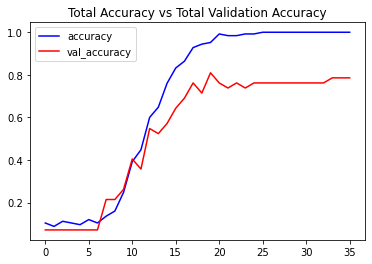

In [17]:
plot_metric(LRCN_model_opt_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

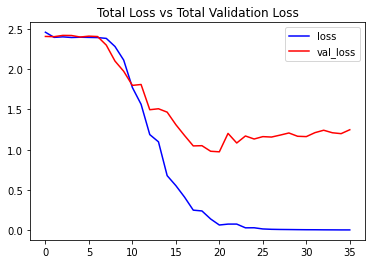

In [18]:
plot_metric(LRCN_model_opt_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss') 

In [21]:
dataset = np.load(f'{DATASET_DIR}/dataset_3.npz')
features=dataset['origin_features']
labels=dataset['labels']
video_files_paths=dataset['video_files_paths']

In [22]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [23]:
LRCN_model_opt = create_LRCN_model_opt()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 120, 160, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 30, 40, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 30, 40, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 30, 40, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 7, 10, 64)   

In [28]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model_opt.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


In [29]:
# Start training the model.
LRCN_model_opt_training_history = LRCN_model_opt.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 1 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/100
125/125 [==============================] - 11s 62ms/step - loss: 2.4024 - accuracy: 0.0720 - val_loss: 2.4045 - val_accuracy: 0.0714
Epoch 2/100
125/125 [==============================] - 7s 53ms/step - loss: 2.3917 - accuracy: 0.0720 - val_loss: 2.3988 - val_accuracy: 0.0714
Epoch 3/100
125/125 [==============================] - 7s 54ms/step - loss: 2.3916 - accuracy: 0.1280 - val_loss: 2.4022 - val_accuracy: 0.0714
Epoch 4/100
125/125 [==============================] - 6s 51ms/step - loss: 2.3634 - accuracy: 0.1280 - val_loss: 2.3584 - val_accuracy: 0.0714
Epoch 5/100
125/125 [==============================] - 7s 54ms/step - loss: 2.3061 - accuracy: 0.1360 - val_loss: 2.2825 - val_accuracy: 0.1429
Epoch 6/100
125/125 [==============================] - 7s 53ms/step - loss: 2.2660 - accuracy: 0.1920 - val_loss: 2.0924 - val_accuracy: 0.1667
Epoch 7/100
125/125 [==============================] - 7s 56ms/step - loss: 2.1206 - accuracy: 0.2080 - val_loss: 2.2329 - val_accuracy